In [71]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [75]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
os.listdir('/content/gdrive/My Drive/vc_modeling/data')

Mounted at /content/gdrive


['crunchbase_bulk_export',
 'timeline.csv',
 'investor_df.csv',
 'success_pct_by_category.csv',
 'organization_founders_features.csv',
 'organization_success.csv',
 'valuation_predictor.ipynb',
 'funding_features.csv']

In [76]:
path_prefix = "/content/gdrive/My Drive/vc_modeling/data/"
feature_csv_filenames = ["organization_founders_features.csv", "funding_features.csv", "organization_success.csv"]
dfs = [pd.read_csv(path_prefix + x) for x in feature_csv_filenames]
df_names = [x[:-4] for x in feature_csv_filenames]
df_dict = dict(zip(df_names, dfs))
df_dict.keys()

dict_keys(['organization_founders_features', 'funding_features', 'organization_success'])

In [ ]:
founders_df = df_dict["organization_founders_features"]
founders_df.head()

,org_uuid,founders_top_rank,founders_top_college,founders_max_degree_type_ordinal,founders_max_degree_count,founders_max_founded_other_org,founders_count
0,000014da-0c46-b9cb-0941-3a93c027b119,265041.0,0.0,2.0,1.0,1.0,4
1,00002470-bff7-6226-5800-0ca1b3787b6f,6551.0,1.0,2.0,2.0,1.0,2
2,00007c5c-9260-0dfb-c160-89a416f1a7cc,180759.0,NaN,NaN,NaN,0.0,2
3,0000b5c1-07dd-aeb6-2b17-eb3d64e652a6,147007.0,0.0,2.0,1.0,0.0,1
4,0000c0e1-eb00-9281-9a7f-63dfa277e8df,289919.0,NaN,NaN,NaN,0.0,1


In [77]:
funding_features_df = df_dict["funding_features"]
funding_features_df.head()

,org_uuid,num_funding_rounds,raised_amount_usd
0,00000aa4-ba42-9b68-a9c3-040c9f3bf9b9,1,8.260736e+07
1,000014da-0c46-b9cb-0941-3a93c027b119,7,NaN
2,00002470-bff7-6226-5800-0ca1b3787b6f,5,1.133333e+06
3,000095de-8e2b-82f1-32a7-c222ba3d5682,1,9.500000e+06
4,0000d497-c93a-eea3-eeb0-a943dfb4f71e,2,4.315760e+05


In [ ]:
timeline_df = df_dict["timeline"]
timeline_df.info()

KeyError: ignored

In [ ]:
org_success = df_dict["organization_success"]
org_success.head()

,uuid,has_succeeded
0,e1393508-30ea-8a36-3f96-dd3226033abd,1
1,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,1
2,4111dc8b-c0df-2d24-ed33-30cd137b3098,1
3,180ebf67-68d0-2316-e93d-8e1e546330ba,1
4,ea091a8c-40e0-0607-e05a-86e734f94ade,1


In [107]:
#timeline_df["has_succeeded"] = timeline_df["has_succeeded"].astype(int)
#timeline_success_df = timeline_df[timeline_df["has_succeeded"] == 1].drop_duplicates(["org_uuid"])[["org_uuid", "has_succeeded"]]
#print("num companies succeeded: " + str(len(timeline_success_df)))

features_df = org_success.join(funding_features_df.set_index("org_uuid"), on="uuid", how="inner")
features_and_success_df = features_df.join(founders_df.set_index("org_uuid"), on="uuid")

features_and_success_df = features_and_success_df.dropna(subset=["has_succeeded"])

cols = list(features_and_success_df.columns)
cols.remove('uuid')
features_and_success_df = features_and_success_df.dropna(how="all", subset=cols)
features_and_success_df[:50]

,uuid,has_succeeded,num_funding_rounds,raised_amount_usd,founders_top_rank,founders_top_college,founders_max_degree_type_ordinal,founders_max_degree_count,founders_max_founded_other_org,founders_count
0,e1393508-30ea-8a36-3f96-dd3226033abd,1,3,1.325000e+07,20738.0,1.0,1.0,2.0,1.0,2.0
1,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,1,6,9.800000e+06,1735.0,0.0,NaN,1.0,0.0,1.0
2,4111dc8b-c0df-2d24-ed33-30cd137b3098,1,3,7.500000e+06,182.0,1.0,3.0,2.0,0.0,2.0
4,ea091a8c-40e0-0607-e05a-86e734f94ade,1,6,1.261055e+07,NaN,NaN,NaN,NaN,NaN,NaN
5,59fada33-1595-de45-b362-062a04cf51cf,1,4,1.103750e+07,NaN,NaN,NaN,NaN,NaN,NaN
7,8cb7f859-e757-0937-a18b-e7992c167203,1,5,8.666667e+06,36775.0,1.0,3.0,3.0,0.0,1.0
8,90e234e5-c045-f851-e6aa-291af5d270fe,1,1,4.500000e+07,1218.0,0.0,2.0,2.0,4.0,3.0
10,e25f4821-7be5-0e51-3962-081fe56265ac,1,2,1.025000e+07,8938.0,1.0,3.0,2.0,0.0,3.0
11,f43648f4-f341-401b-3b0e-0219683e9ada,1,7,5.350000e+06,173207.0,0.0,1.0,1.0,2.0,1.0
12,fc89cfde-a28e-e12c-443c-edccb6c93fd4,1,7,1.216667e+07,26459.0,1.0,2.0,3.0,1.0,4.0


In [108]:
len(features_and_success_df[features_and_success_df["has_succeeded"]==1])

24298

Testing Logistic Regression model...
      p     n
Y  7198  3060
N    80    99
error: 0.3008527354603813
roc auc: 0.7134954448207146

Testing CART model...
      p     n
Y  6767  2011
N   511  1148
error: 0.2416403180990706
roc auc: 0.7257277468447427

Testing Random Forest model...
      p     n
Y  6684  1957
N   594  1202
error: 0.2444188943182907
roc auc: 0.721521879955172



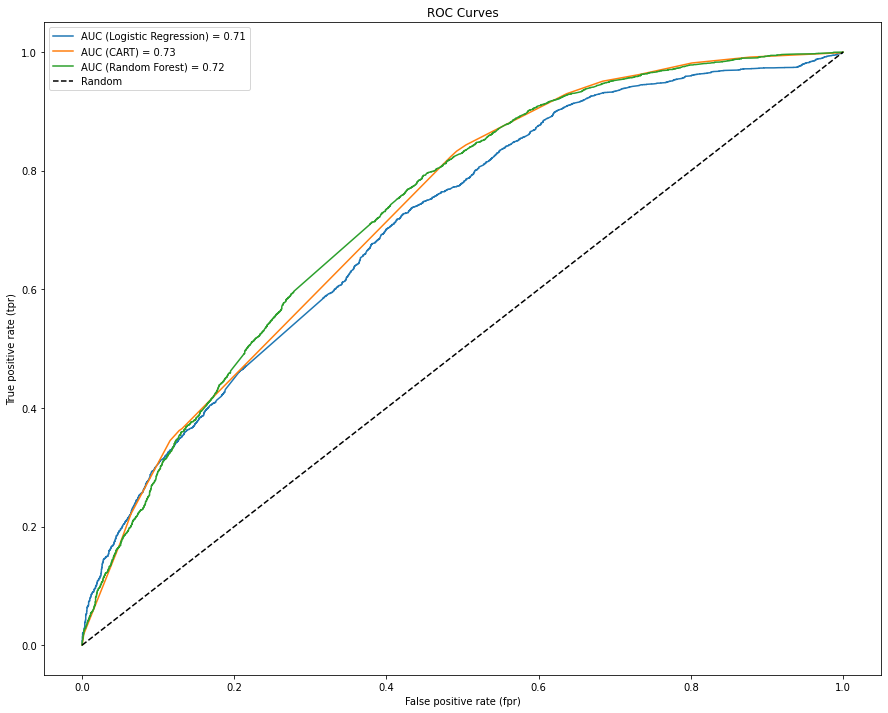

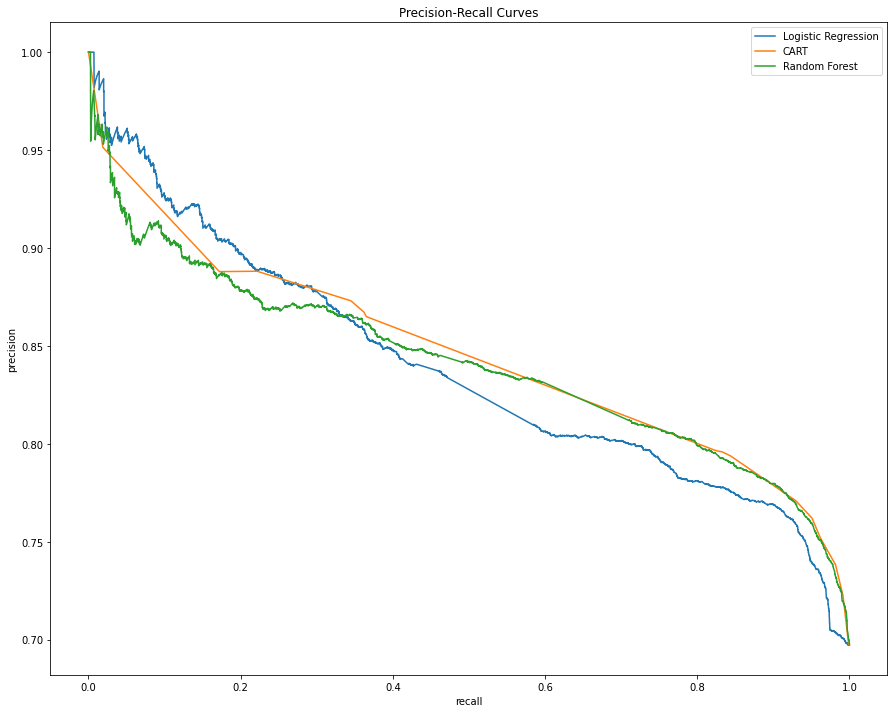

In [110]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12

modelConfigs = [
    {'label': 'Logistic Regression', 'model': LogisticRegression(C=1., solver='liblinear')},
    {'label': 'CART', 'model': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')},
    {'label': 'Random Forest', 'model': RandomForestClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=400, random_state=42)}
]

data = features_and_success_df
Y = data['has_succeeded']
X = data.drop(['uuid', 'founders_top_rank', 'has_succeeded'], axis=1)

# standardize columns
X[:] = StandardScaler().fit_transform(X[:])

# impute missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X)
X[:] = imp.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

modelData = []

for config in modelConfigs:
    print("Testing " + config['label'] + " model...")
    model = config['model']

    pipe = Pipeline(steps=[('model', model)])

    pipe.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = pipe.predict_proba(X_test)[:, 1]
    
    prediction = Y_test_probability_1 > 0.50

    # Build and print a confusion matrix
    confusion_matrix = metrics.confusion_matrix(Y_test, prediction, labels=[1, 0])
    confusion_matrix_large = pd.DataFrame(confusion_matrix.T, columns=['p', 'n'], index=['Y', 'N'])
    
    # Compute tp, fp, tn and fn to compute error
    tp = confusion_matrix[0][0]
    fp = confusion_matrix[0][1]
    tn = confusion_matrix[1][1]
    fn = confusion_matrix[1][0]
    error = (fp + fn) / (tp + fp + tn + fn)
    print(confusion_matrix_large)
    print("error: " + str(error))

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    # Get the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc", cv=5))
    print("roc auc: " + str(auc))

    # Calculate precision-recall
    precision, recall, _ = precision_recall_curve(Y_test, Y_test_probability_1)
    # Store model data to plot later
    modelData.append({'config': config, 'fpr': fpr, 'tpr': tpr, 'auc': auc, 'precision': precision, 'recall': recall})
    
    print("")
    
# plot ROC curves
for x in modelData:
    fpr = x['fpr']
    tpr = x['tpr']
    plt.plot(fpr, tpr, label="AUC (" + x['config']['label'] + ") = " + str(round(x['auc'], 2)))

plt.title("ROC Curves")
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc='best')

# plot precision-recall curves
plt.figure()
plt.title("Precision-Recall Curves")
for x in modelData:
    precision = x['precision']
    recall = x['recall']
    plt.plot(recall, precision, label=x['config']['label'])

plt.ylabel("precision")
plt.xlabel("recall")
plt.legend(loc='best')

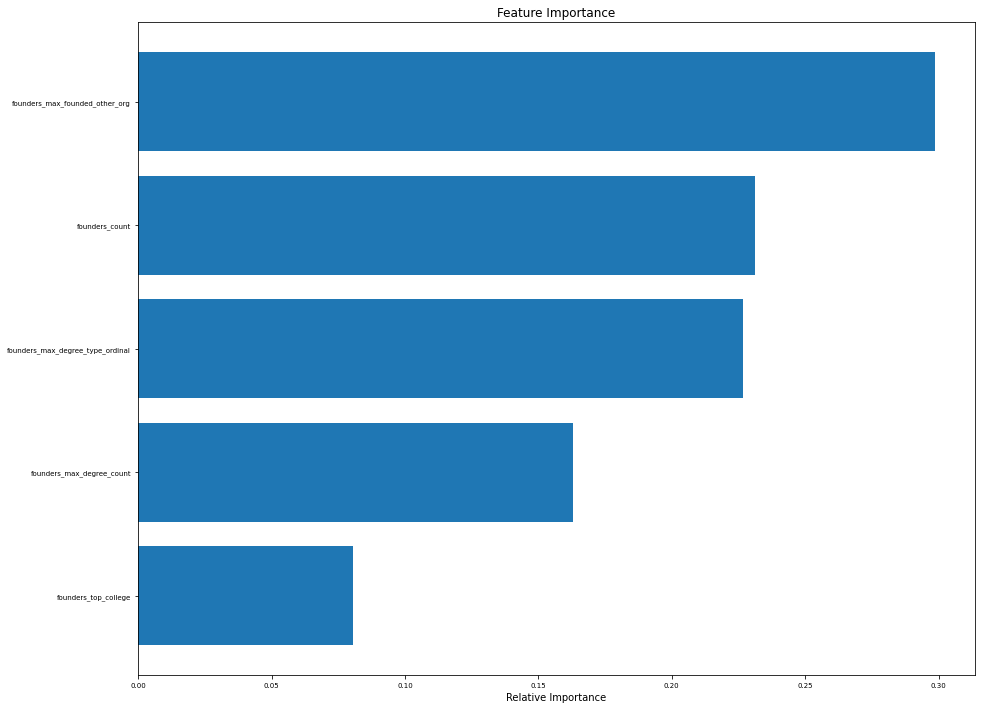

Features ranked by importance (1st is most important): ['founders_max_founded_other_org', 'founders_count', 'founders_max_degree_type_ordinal', 'founders_max_degree_count', 'founders_top_college']


In [ ]:
# Rank importance of features using Random Forest

clf = RandomForestClassifier()
clf.fit(X, Y)

features = X.columns
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(features))
plt.barh(padding, importances[sorted_idx], align='center')
plt.tick_params(labelsize=7)
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Feature Importance")
plt.show()

features_by_importance = [features[idx] for idx in sorted_idx]
features_by_importance.reverse()
print("Features ranked by importance (1st is most important): " + str(features_by_importance))

In [ ]:
# Parameter Tuning

# Create an scaler object
sc = StandardScaler()

# Create a pca object
pca = PCA()

# Create a logistic regression object with an L2 penalty
decisiontree = DecisionTreeClassifier()
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

# Create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('sc', sc),
                        ('pca', pca),
                        ('decisiontree', decisiontree)])

# Create Parameter Space
# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12,20]
min_samples_split = [2, 4, 6, 8]
min_samples_leaf = [1, 2, 3, 5]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                  decisiontree__criterion=criterion,
                  decisiontree__max_depth=max_depth,
                  decisiontree__min_samples_split=min_samples_split,
                  decisiontree__min_samples_leaf=min_samples_leaf)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)

# Fit the grid search
clf.fit(X, Y)

# View The Best Parameters
print(); print(clf.best_estimator_.get_params()['decisiontree'])

# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X, Y, cv=4, n_jobs=-1, scoring="roc_auc")
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[0.56825169 0.53875767 0.54628233 0.52547859]

0.544692569575751

0.015507737855002424
